## 最適化問題の書き換え

$$ \min_H \|G-HF\|_F^2+\lambda\|H\|_1 $$
$$ \downarrow $$
$$ \min_h \|\bm{g}-F^\top \bm{h}\|_2^2+\lambda\|\bm{h}\|_1 $$
ただし、

$$
H=(\bm{h}_1\cdots\bm{h}_N), \;
\bm{h}=\left(\begin{matrix}
\bm{h}_1\\
\vdots\\
\bm{h}_N
\end{matrix}\right)\\
G=(\bm{g}_1\cdots\bm{g}_K), \;
\bm{g}=\left(\begin{matrix}
\bm{g}_1\\
\vdots\\
\bm{g}_K
\end{matrix}\right)
$$


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

In [24]:
# パラメータ設定
n = 64
m = 128
LAMBDA = 1
SEED = 2
RATIO = 0.1
DATA_PATH = '../../OneDrive - m.titech.ac.jp/Lab/data'
IMG_NAME = 'hadamard'
DIRECTORY = DATA_PATH + '/240620'
SETTING=f"l1_p-{int(100*RATIO)}_lmd-{int(LAMBDA)}"

In [13]:
def matrix2vector(matrix):
    return matrix.T.flatten()


def vector2matrix(vector, s, t):
    return vector.reshape(s, t).T


def mult_mass(F, h, M):
    N = F.shape[1]
    h = h.reshape(N, M)
    res = F @ h
    return res.flatten()


def images_to_matrix(folder_path, convert_gray=True, disp_used=False, rand=True, ratio=RATIO):
    files = os.listdir(folder_path)
    files.sort(key=lambda f: int(re.search(f"{IMG_NAME}_(\d+).png", f).group(1)))
    if rand:
        random.seed(SEED)
        random.shuffle(files)

    total_files = len(files)
    number_of_files_to_load = int(total_files * ratio)
    selected_files = files[:number_of_files_to_load]
    selected_files.sort(key=lambda f: int(re.search(f"{IMG_NAME}_(\d+).png", f).group(1)))

    images = []
    use_list = []

    for file in selected_files:
        index = int(re.sub(r'\D', '', file))
        use_list.append(index)
        img = Image.open(os.path.join(folder_path, file))
        if convert_gray:
            img = img.convert('L')
        img_array = np.asarray(img).flatten()
        img_array = img_array / 255
        images.append(img_array)

    if disp_used:
        print("Used:", use_list)

    return np.column_stack(images)

In [18]:
def fista(F, g, lmd, prox, max_iter=300, tol=1e-3):
    """
    Solve the optimization problem using FISTA:
    min_h ||g - Fh||_2^2 + lambda * ||h||_1

    Parameters:
    - F: numpy array, the matrix F
    - g: numpy array, the vector g
    - lmd: float, the regularization parameter
    - max_iter: int, the maximum number of iterations
    - tol: float, the tolerance for convergence

    Returns:
    - h: numpy array, the solution vector h
    """
    # Initialize variables
    n = F.shape[1]
    t = 1
    h = np.zeros(m * m * n)
    y = np.zeros(m * m * n)

    # Lipschitz constant
    L = np.linalg.norm(F.T @ F, ord=2) * 2
    print(f"L: {L}")
    gamma = 1 / L

    for i in range(max_iter):
        grad = mult_mass(F.T, (mult_mass(F, y, m * m) - g), m * m)
        h_new = prox(y - gamma * grad, gamma * lmd)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y_new = h_new + (t - 1) / t_new * (h_new - h)

        error = np.linalg.norm(y_new - y)
        print(f"iter: {i}, error: {error}")
        if error < tol:
            break

        t = t_new.copy()
        h = h_new.copy()
        y = y_new.copy()

    return y_new


def prox_l1(u, tau):
    """Soft thresholding operator for L1 norm."""
    return np.sign(u) * np.maximum(np.abs(u) - tau, 0)

In [19]:
# load images
G = images_to_matrix(f"{DATA_PATH}/{IMG_NAME}{n}_cap_R_230516_128/", disp_used=True)
F = images_to_matrix(f"{DATA_PATH}/{IMG_NAME}{n}_input/", disp_used=True)
print("K=", F.shape[1])
white = Image.open(f"{DATA_PATH}/{IMG_NAME}{n}_cap_R_230516_128/{IMG_NAME}_1.png")
white = white.convert('L')
white = np.asarray(white).flatten() / 255
white = white[:, np.newaxis]
H1 = np.tile(white, F.shape[1])
F_hat = 2 * F - 1
G_hat = 2 * G - H1

g = matrix2vector(G_hat)

Used: [17, 32, 38, 62, 63, 68, 70, 78, 83, 85, 89, 91, 117, 120, 124, 150, 170, 173, 181, 191, 205, 207, 209, 213, 216, 239, 249, 250, 268, 293, 322, 323, 332, 338, 349, 357, 358, 363, 372, 405, 406, 421, 442, 451, 466, 483, 503, 516, 520, 534, 562, 570, 579, 582, 616, 623, 632, 645, 650, 653, 671, 675, 678, 683, 688, 706, 723, 728, 729, 730, 735, 736, 739, 774, 775, 776, 798, 800, 805, 833, 857, 872, 874, 894, 915, 952, 958, 963, 998, 1001, 1002, 1005, 1012, 1017, 1035, 1041, 1044, 1051, 1060, 1069, 1088, 1092, 1097, 1105, 1106, 1108, 1112, 1132, 1148, 1151, 1161, 1170, 1171, 1178, 1201, 1218, 1229, 1235, 1238, 1244, 1256, 1270, 1292, 1295, 1300, 1321, 1323, 1331, 1341, 1346, 1354, 1362, 1375, 1388, 1389, 1406, 1418, 1419, 1420, 1448, 1464, 1484, 1501, 1503, 1507, 1512, 1521, 1550, 1561, 1571, 1575, 1589, 1591, 1615, 1623, 1625, 1628, 1639, 1658, 1681, 1688, 1695, 1700, 1705, 1711, 1727, 1743, 1753, 1754, 1781, 1782, 1785, 1799, 1801, 1807, 1809, 1819, 1839, 1840, 1853, 1857, 1877, 18

In [20]:
h = fista(F_hat.T, g, LAMBDA, prox_l1)

L: 8192.000000000022
iter: 0, error: 0.941503962724137
iter: 1, error: 0.6722693891900702
iter: 2, error: 0.4618479130691296
iter: 3, error: 0.36556604279237875
iter: 4, error: 0.34233803123613155
iter: 5, error: 0.34015488746077804
iter: 6, error: 0.3410853811868619
iter: 7, error: 0.34235381060562986
iter: 8, error: 0.34370497728917565
iter: 9, error: 0.3450369574235273
iter: 10, error: 0.3463322849069407
iter: 11, error: 0.34752804653565783
iter: 12, error: 0.3485432904449646
iter: 13, error: 0.3492939249534854
iter: 14, error: 0.349542532096615
iter: 15, error: 0.34919676051113313
iter: 16, error: 0.34799757321858366
iter: 17, error: 0.3457254620547842
iter: 18, error: 0.34213466174297424
iter: 19, error: 0.3369615845253561
iter: 20, error: 0.329981361283348
iter: 21, error: 0.3209831907713321
iter: 22, error: 0.3098715972582426
iter: 23, error: 0.29666502423116564
iter: 24, error: 0.2815616069255665
iter: 25, error: 0.26494743324793685
iter: 26, error: 0.24739784072935725
iter: 27

In [ ]:
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
if not os.path.exists(DIRECTORY + '/systemMatrix'):
    os.makedirs(DIRECTORY + '/systemMatrix')

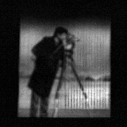

In [25]:
H = vector2matrix(h, n**2, m**2)
np.save(f"{DIRECTORY}/systemMatrix/H_matrix_hadamard_{SETTING}.npy", H)

sample_image = Image.open(f"{DATA_PATH}/sample_image64/Cameraman64.png").convert('L')
sample_image = np.asarray(sample_image).flatten() / 255

Hf = H @ sample_image
Hf_img = Hf.reshape(m, m)
Hf_img = np.clip(Hf_img, 0, 1)
Hf_pil = Image.fromarray((Hf_img * 255).astype(np.uint8), mode='L')

FILENAME = f"Cameraman64_{SETTING}.png"
fig, ax = plt.subplots(figsize=Hf_img.shape[::-1], dpi=1, tight_layout=True)
ax.imshow(Hf_pil, cmap='gray')
ax.axis('off')
fig.savefig(f"{DIRECTORY}/{FILENAME}", dpi=1)
plt.show()

In [26]:
H_true = np.load(f"{DATA_PATH}/systemMatrix/H_matrix_true.npy")
rem = np.linalg.norm(H_true-H, 'fro')
print(rem)

1.686803935325861
